<a href="https://colab.research.google.com/github/FiorenSt/Machine-Learning-In-Astronomy-Tutorial/blob/main/DeblendingGalaxiesTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TUTORIAL on Galaxy deblending with Deep Learning

###Edited by Fiorenzo Stoppa  

###### Based on the work of Alexandre Boucaud (APC) & Marc Huertas-Company (LERMA) 

1. [Introduction](#Introduction)
2. [Data](#Data)
3. [Workflow](#Workflow)
4. [Evaluation](#Detection-evaluation)
5. [Local testing/exploration](#Local-testing)

## Introduction

In astronomical images, the projection effects may cause two or more galaxies to overlap. When they are barely indistinguishable from one another, they are referred to as _blended_ and this can bias astrophysical estimators such as the morphology of galaxies or the shear (weak gravitational lensing distortion).  
As the sensitivity of imaging devices grows, a high fraction of galaxies appear _blended_ in the images, which is a known and important issue for current and upcoming galaxy surveys. It is key to develop methods to enable astronomers to alleviate such effect.
We can foresee some features that would help, in which machine learning could provide a solution:
- classify an image as containing isolated/blended objects  
  ___binary classification___
- count the number of blended sources in a blended image  
  ___object detection___
- find the contours of each object  
  ___segmentation___
- ...

In this tutorial, we will try to identify and localize the **companion** galaxy. Each image contain **two galaxies** and the goal will be to find the **contours of the companion galaxy**.


# Code

Install the `dltools` lib that contains helper methods for training a deep neural network on the provided blended galaxy dataset.

In [1]:
!pip install -q git+https://github.com/aboucaud/deeplearning4astro_tools

     |████████████████████████████████| 462 kB 5.1 MB/s 


## Necessary imports

In [2]:
import os
import sys
import tarfile
from urllib.request import urlretrieve

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from dltools.plots import plot_random_results

## Data

Download the data

In [4]:
datadir = "data"
# Use the big dataset (during the school, use this only on Colab, otherwise set to False)
full = True

In [5]:
URL = "https://www.apc.univ-paris7.fr/Downloads/comput/aboucaud"
FOLDER = "ed127"
FILES = [
    "test_blends_mini.npy",
    "test_target_masks_mini.npy",
    "train_blends_mini.npy",
    "train_target_masks_mini.npy",

]
BIG_FILES = [
    "masks.tar.gz",
    "blends.tar.gz",
]

def main(output_dir, delete_archive=False, full=False):
    if full:
        files = BIG_FILES
    else:
        files = FILES

    urls = [
        f"{URL}/{FOLDER}/{filename}"
        for filename in files
    ]

    if not os.path.exists(output_dir):
        print(f"Creating directory {output_dir}")
        os.mkdir(output_dir)

    for url, filename in zip(urls, files):
        output_file = os.path.join(output_dir, filename)

        if os.path.exists(output_file):
            print(f"{filename} already downloaded.")
            continue

        print(f"Downloading from {url} ...")
        urlretrieve(url, filename=output_file)
        print(f"=> File saved as {output_file}")

        if filename.endswith("tar.gz"):
            print("Extracting tarball..")
            with tarfile.open(output_file, "r:gz") as f:
                f.extractall(output_dir)
            print("Done.")

            if delete_archive:
                os.remove(output_file)
                print(f"=> File {output_file} removed.")

In [6]:
main(output_dir=datadir, full=full, delete_archive=True)                

Creating directory data
=> File saved as data/masks.tar.gz
Extracting tarball..
Done.
=> File data/masks.tar.gz removed.
=> File saved as data/blends.tar.gz
Extracting tarball..
Done.
=> File data/blends.tar.gz removed.


## Load data

Load the train and test datasets in memory-mapping mode. This does not actually load the data into memory but creates a mapping to it to easily retrieve chunks of the data using its indices when needed. 

In [7]:
suffix = "" if full else "_mini"

X_train = np.load(os.path.join(datadir, f"train_blends{suffix}.npy"), mmap_mode='r')
Y_train = np.load(os.path.join(datadir, f"train_target_masks{suffix}.npy"), mmap_mode='r')[:, 1, :, :]

X_test = np.load(os.path.join(datadir, f"test_blends{suffix}.npy"), mmap_mode='r')
Y_test = np.load(os.path.join(datadir, f"test_target_masks{suffix}.npy"), mmap_mode='r')[:, 1, :, :]

In [17]:
def plot_data_basic(idx):
    titles = [
        'blended galaxies',
        'segmap of companion galaxy'
    ]

    fig_size = (12, 6)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=fig_size)
    axes[0].imshow(X_train[idx], cmap='viridis')
    axes[1].imshow(Y_train[idx], cmap='Greys_r')
    for title, ax in zip(titles, axes):
        ax.set_title(title)
        ax.set_axis_off()


def plot_random_results(X_test, y_test, y_pred):
        n_gal = 5
        idx = np.random.randint(0, len(y_test), size=n_gal)
        X = X_test[idx]
        if X.ndim == 3:
            X = np.expand_dims(X, -1)
        y_true = y_test[idx]
        y_pred = y_pred[idx]

        titles = [
            'blend',
            'true segmentation',
            'output',
            'output thresholded',
        ]
        fig_size = (10, 12)
        fig, ax = plt.subplots(nrows=n_gal, ncols=4, figsize=fig_size)
        for i in range(n_gal):
            img = np.squeeze(X[i])
            yt = np.squeeze(y_true[i])
            yp = np.squeeze(y_pred[i])
            ax[i, 0].imshow(img)
            ax[i, 1].imshow(yt)
            ax[i, 2].imshow(yp)
            ax[i, 3].imshow(yp.round())
            if i == 0:
                for idx, a in enumerate(ax[i]):
                    a.set_title(titles[idx])
            for a in ax[i]:
                a.set_axis_off()
        #plt.savefig('{filename}'.format(filename=filename))

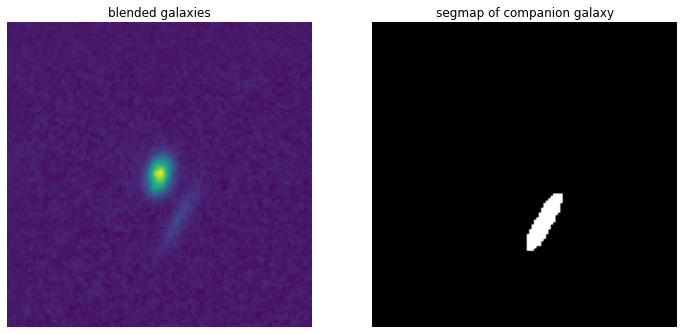

In [18]:
index = np.random.randint(len(X_train))
plot_data_basic(index)

The goal in this exercise is to create a deep learning model that produces the segmentation map (mask) of the companion galaxy from the image of the blend. This can be seen as a classification task where each pixel of the image has to be classified as "galaxy companion" or "not galaxy companion".

## Model (HERE YOUR HELP IS NEEDED)

The model is the part where you intervention is needed. A very basic (working) model is implemented below. It has two convolution layers. While it is very fast to train, it does not yield good results.

Try to navigate the web/github to find appropriate models for this image segmentation task. Or build upon this existing model by complexifying it.

In [10]:
import tensorflow as tf

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1


#Inputs
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

def model(inputs):

    x = inputs

    # Convlution layer 
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    
    # Convolution layer
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model


###################################
# Call the Model
###################################

Model=model(inputs)

Model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
Model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 1)       17        
                                                                 
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [11]:
##########################
# Fit the Model
##########################

# CHANGE HERE THE NUMBER OF EPOCHS OR THE BATCH SIZE
history=Model.fit(X_train,Y_train, batch_size=16,epochs=10, verbose=1, shuffle=True, validation_split=.2)


Epoch 1/10
400/400 [==============================] - 16s 6ms/step - loss: 0.6605 - accuracy: 0.9573 - val_loss: 0.6252 - val_accuracy: 0.9637
Epoch 2/10
400/400 [==============================] - 2s 6ms/step - loss: 0.5871 - accuracy: 0.9634 - val_loss: 0.5474 - val_accuracy: 0.9644
Epoch 3/10
400/400 [==============================] - 2s 6ms/step - loss: 0.5076 - accuracy: 0.9639 - val_loss: 0.4676 - val_accuracy: 0.9648
Epoch 4/10
400/400 [==============================] - 2s 6ms/step - loss: 0.4299 - accuracy: 0.9644 - val_loss: 0.3929 - val_accuracy: 0.9652
Epoch 5/10
400/400 [==============================] - 2s 6ms/step - loss: 0.3598 - accuracy: 0.9649 - val_loss: 0.3277 - val_accuracy: 0.9657
Epoch 6/10
400/400 [==============================] - 2s 6ms/step - loss: 0.3001 - accuracy: 0.9654 - val_loss: 0.2736 - val_accuracy: 0.9662
Epoch 7/10
400/400 [==============================] - 2s 6ms/step - loss: 0.2513 - accuracy: 0.9658 - val_loss: 0.2300 - val_accuracy: 0.9666
Epoch

### Plot the history

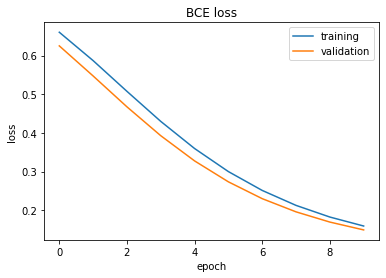

In [12]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('BCE loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])



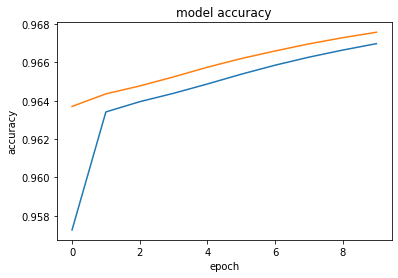

In [13]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['val_accuracy'])


# Predict on the test set and score the model

In [19]:
Y_pred = Model.predict(X_test)[:,:,:,0] 

## Detection evaluation

For image detection a classical metric is the ***Dice coefficient*** also referred to as ***F1 score*** and defined as

$$ Dice(A, B) =  \dfrac{2 \times |A \cap B|}{|A| + |B|} $$

A perfect match would result in a Dice of 1. 


In [20]:
###########################
# Dice Coefficient
##########################

def dice_coeff(y_true, y_pred, smooth=1e-4):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.keras.backend.sum(y_true * y_pred, axis=(0, 1))
    union = tf.keras.backend.sum(y_true, axis=(0, 1)) + tf.keras.backend.sum(y_pred, axis=(0, 1))
    dice = (2. * intersection + smooth)/(union + smooth)
    return dice

print(f"Score: {np.mean(dice_coeff(Y_test,Y_pred)):.2f}")


Score: 0.14


### Plot some examples

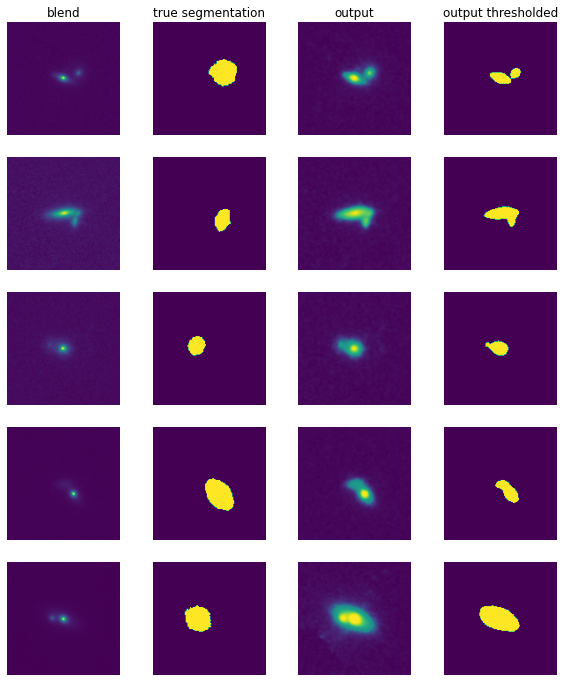

In [21]:
plot_random_results(X_test, Y_test, Y_pred)

# !!!!!!!!!!!!!!!!!!!!!! SAVE YOUR HIGHEST SCORE HERE ....  !!!!!!!!!!!!!!!!!!!!!!!!!!!

##THE ONE WITH THE HIGHEST SCORE AT THE END OF THE LECTURE WINS (SOMETHING)